In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
clean_tx_transation = pd.read_pickle(f'sorted_clean_tx_transation.pkl')

In [3]:
len(clean_tx_transation)

11151729

In [4]:
clean_tx_transation.describe()

,sku,saledate,quantity,orgprice,amt,packsize,cost,lagged_amt,lagged_orgprice
count,1.115173e+07,11151729,11151729.0,1.115173e+07,1.115173e+07,1.115173e+07,1.115173e+07,1.115173e+07,1.115173e+07
mean,4.902134e+06,2005-03-26 10:06:01.152174720,1.0,2.852986e+01,2.250619e+01,1.997009e+00,1.313708e+01,2.489730e+01,2.852504e+01
min,1.560000e+02,2004-08-01 00:00:00,1.0,1.000000e-02,1.000000e-02,1.000000e+00,1.000000e-02,1.000000e-02,1.000000e-02
25%,2.604100e+06,2004-12-29 00:00:00,1.0,1.400000e+01,1.000000e+01,1.000000e+00,6.900000e+00,1.200000e+01,1.400000e+01
50%,4.666618e+06,2005-04-13 00:00:00,1.0,2.100000e+01,1.750000e+01,1.000000e+00,1.050000e+01,1.943000e+01,2.100000e+01
75%,7.278403e+06,2005-07-01 00:00:00,1.0,3.900000e+01,2.900000e+01,3.000000e+00,1.715000e+01,3.250000e+01,3.900000e+01
max,9.999997e+06,2005-08-27 00:00:00,1.0,1.390000e+02,1.390000e+02,6.000000e+00,5.880000e+01,1.390000e+02,1.390000e+02
std,2.842654e+06,NaN,0.0,2.127366e+01,1.794857e+01,1.471406e+00,9.783157e+00,1.974849e+01,2.127200e+01


In [5]:
train_threshold = pd.to_datetime('2005-07-31')
cutoff = clean_tx_transation[clean_tx_transation['saledate'] <= train_threshold]['orgprice'].quantile(0.85)
print(f'quartile: {cutoff}')

quartile: 49.5


In [6]:
clean_tx_transation_copy = clean_tx_transation.copy()
clean_tx_transation = clean_tx_transation[clean_tx_transation['orgprice'] <= cutoff]

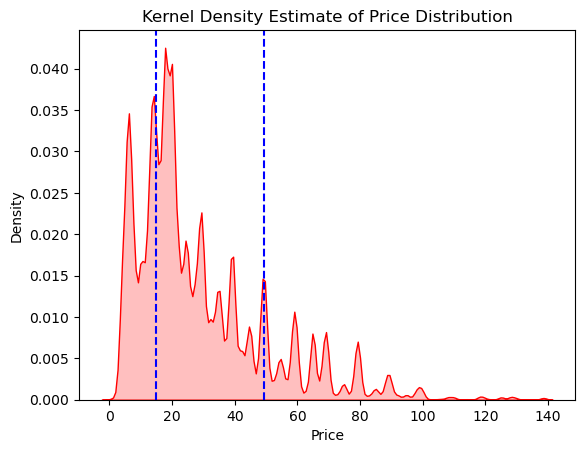

In [7]:
sns.kdeplot(clean_tx_transation_copy['orgprice'], fill=True, color='red')
# Draw a vertical line at a specific x-axis position (e.g., x=50)
plt.axvline(x=15, color='blue', linestyle='--')
plt.axvline(x=cutoff, color='blue', linestyle='--')

# Set the title and labels
plt.title('Kernel Density Estimate of Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')

# Show the plot
plt.show()

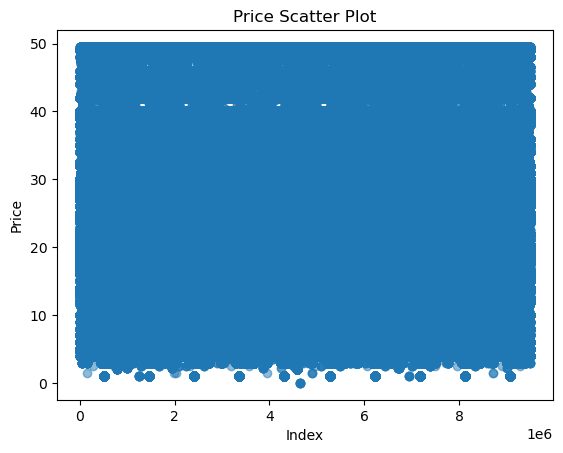

In [8]:
# Create a scatter plot
plt.scatter(range(len(clean_tx_transation)), clean_tx_transation['orgprice'], alpha=0.5)

# Add labels and title
plt.title('Price Scatter Plot')
plt.xlabel('Index')
plt.ylabel('Price')

# Show the plot
plt.show()

# Modeling

### Split train-test set based on a time threshold

In [9]:
clean_tx_transation.head()

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,holiday,month,quarter,weekday,lagged_amt,lagged_orgprice
0,262,1007,2005-08-07,1,4.0,2.0,1.0,JOLIE IN,0.95,CARTERS,False,August,3,Sunday,4.0,4.0
1,262,1007,2005-08-12,1,4.0,2.0,1.0,JOLIE IN,0.95,CARTERS,False,August,3,Friday,2.0,4.0
2,262,1807,2005-06-03,1,4.0,4.0,1.0,JOLIE IN,0.95,CARTERS,False,June,2,Friday,4.0,4.0
3,262,1807,2005-08-13,1,4.0,2.0,1.0,JOLIE IN,0.95,CARTERS,False,August,3,Saturday,4.0,4.0
4,262,2607,2005-08-08,1,4.0,2.0,1.0,JOLIE IN,0.95,CARTERS,False,August,3,Monday,4.0,4.0


In [10]:
# 1. Split into X and y dataset
X = clean_tx_transation.drop(columns=['amt','sku', 'brand'])
y = clean_tx_transation['amt']

# 2. Split X, y into train set and test set based on a time threshold
train_threshold = pd.to_datetime('2005-07-31')

X_train = X[X['saledate'] <= train_threshold]
X_test = X[X['saledate'] > train_threshold]
y_train = y[X['saledate'] <= train_threshold]
y_test = y[X['saledate'] > train_threshold]

X_train = X_train.drop(columns=['saledate'])
X_test = X_test.drop(columns=['saledate'])

print(len(X_train))
print(len(X_test))

8480715
1018434


In [11]:
X_train = X_train.sample(n=1200000, random_state=123)
y_train = y_train.loc[X_train.index]
X_test = X_test.sample(n=300000, random_state=123)
y_test = y_test.loc[X_test.index]

In [12]:
test_with_sku = clean_tx_transation.loc[X_test.index]

In [13]:
len(test_with_sku)

300000

In [14]:
cutoff = 15
bins = [float('-inf'), cutoff, float('inf')]
labels = ['Cheap', 'Normal']

X_train['price_category'] = pd.cut(X_train['orgprice'], bins=bins, labels=labels, include_lowest=True)
print(X_train[['orgprice', 'price_category']])
X_test['price_category'] = pd.cut(X_test['orgprice'], bins=bins, labels=labels, include_lowest=True)
print(X_test[['orgprice', 'price_category']])

          orgprice price_category
3742998       45.0         Normal
909851        32.0         Normal
5463443       14.5          Cheap
1823789       13.5          Cheap
3351950       18.5         Normal
...            ...            ...
6582289       28.0         Normal
10873452      11.0          Cheap
2707849       16.5         Normal
4724206        8.0          Cheap
8347498       11.0          Cheap

[1200000 rows x 2 columns]
         orgprice price_category
3793362      39.0         Normal
9289565      18.0         Normal
8867056      20.0         Normal
3841995      10.0          Cheap
3619016      27.0         Normal
...           ...            ...
7477956      32.0         Normal
6679896      29.0         Normal
7760290      18.0         Normal
1783335      34.0         Normal
7235004      10.0          Cheap

[300000 rows x 2 columns]


In [15]:
test_with_sku.loc[(test_with_sku['orgprice'] <= cutoff), 'price_category'] = 'Cheap'
test_with_sku.loc[(test_with_sku['orgprice'] > cutoff), 'price_category'] = 'Normal'

In [16]:
# Group by 'month' and 'price_category', get counts, and unstack
grouped_data = X_train.groupby(['month', 'price_category']).size().unstack()
# Normalize the counts to get percentages
grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
grouped_data_percentage = grouped_data_percentage.reset_index()

# Define the custom order of months
custom_month_order = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']

# Create a categorical data type with the custom order
month_dtype = pd.CategoricalDtype(categories=custom_month_order, ordered=True)
grouped_data_percentage['month'] = grouped_data_percentage['month'].astype(month_dtype)
# Sort the DataFrame by the custom order of 'month'
grouped_data_percentage_sorted = grouped_data_percentage.sort_values(by='month').reset_index(drop=True)
grouped_data_percentage_sorted

price_category,month,Cheap,Normal
0,August,40.782199,59.217801
1,September,39.933215,60.066785
2,October,40.803778,59.196222
3,November,41.421303,58.578697
4,December,40.332987,59.667013
5,January,43.328970,56.671030
6,February,39.855853,60.144147
7,March,32.283685,67.716315
8,April,33.996210,66.003790
9,May,30.449106,69.550894


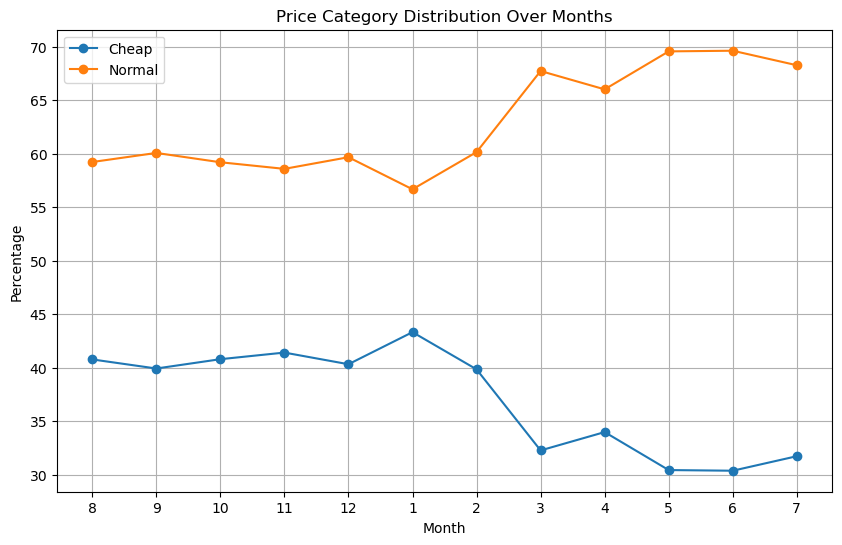

In [17]:
# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(grouped_data_percentage_sorted['month'], grouped_data_percentage_sorted['Cheap'], label='Cheap', marker='o')
plt.plot(grouped_data_percentage_sorted['month'], grouped_data_percentage_sorted['Normal'], label='Normal', marker='o')
# plt.plot(grouped_data_percentage_sorted['month'], grouped_data_percentage_sorted['Expensive'], label='Expensive', marker='o')

plt.title('Price Category Distribution Over Months')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
# Customize the x-axis ticks
custom_ticks = [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
plt.xticks(grouped_data_percentage_sorted['month'], custom_ticks)

plt.show()

In [18]:
# Group by 'month' and 'price_category', get counts, and unstack
grouped_data = X_test.groupby(['month', 'price_category']).size().unstack()
# Normalize the counts to get percentages
grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
grouped_data_percentage

price_category,Cheap,Normal
month,,
August,28.264,71.736


# Observation
Stable sales for 'normal' items, rising sales for 'expensive' items, and declining sales for 'cheap' items.

<Axes: xlabel='price_category'>

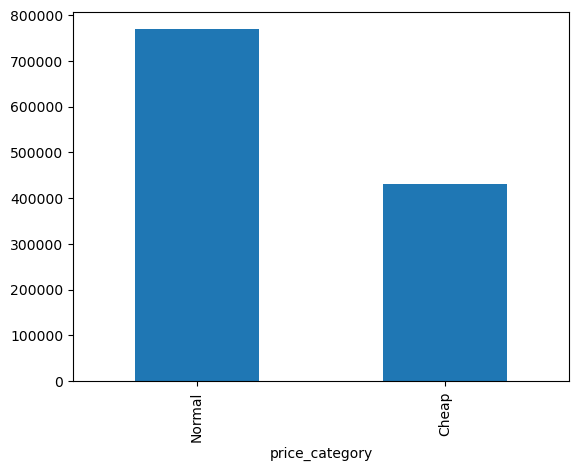

In [19]:
X_train['price_category'].value_counts().plot(kind='bar')

<Axes: xlabel='price_category'>

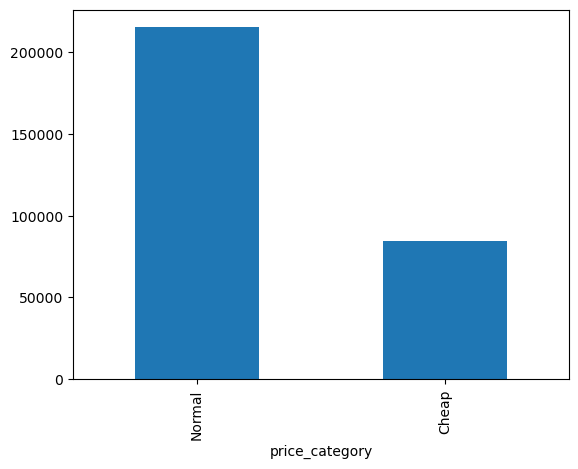

In [20]:
X_test['price_category'].value_counts().plot(kind='bar')

In [21]:
X_train_cheap = X_train[X_train['price_category'] == 'Cheap'].drop('price_category', axis=1)
X_test_cheap = X_test[X_test['price_category'] == 'Cheap'].drop('price_category', axis=1)

y_train_cheap = y_train[X_train['price_category'] == 'Cheap']
y_test_cheap = y_test[X_test['price_category'] == 'Cheap']

print("Number of 'Cheap' samples in training set:", len(X_train_cheap))
print("Number of 'Cheap' samples in test set:", len(X_test_cheap))

Number of 'Cheap' samples in training set: 430456
Number of 'Cheap' samples in test set: 84792


In [22]:
print(X_train_cheap.describe())
print(X_test_cheap.describe())

       quantity       orgprice       packsize           cost     lagged_amt  \
count  430456.0  430456.000000  430456.000000  430456.000000  430456.000000   
mean        1.0       9.667138       2.689522       4.572028       8.497294   
std         0.0       3.739422       1.858192       2.554243       4.348987   
min         1.0       0.010000       1.000000       0.010000       0.010000   
25%         1.0       6.000000       1.000000       2.100000       5.000000   
50%         1.0      10.000000       3.000000       4.050000       8.000000   
75%         1.0      13.500000       3.000000       6.900000      13.500000   
max         1.0      15.000000       6.000000      15.000000      25.000000   

       lagged_orgprice  
count    430456.000000  
mean          9.665231  
std           3.739906  
min           0.010000  
25%           6.000000  
50%          10.000000  
75%          13.500000  
max          55.000000  
       quantity      orgprice      packsize          cost    la

In [23]:
X_train_normal = X_train[X_train['price_category'] == 'Normal'].drop('price_category', axis=1)
X_test_normal = X_test[X_test['price_category'] == 'Normal'].drop('price_category', axis=1)

y_train_normal = y_train[X_train['price_category'] == 'Normal']
y_test_normal = y_test[X_test['price_category'] == 'Normal']

print("Number of 'Normal' samples in training set:", len(X_train_normal))
print("Number of 'Normal' samples in test set:", len(X_test_normal))

Number of 'Normal' samples in training set: 769544
Number of 'Normal' samples in test set: 215208


In [24]:
print(X_train_normal.describe())
print(X_test_normal.describe())

       quantity       orgprice       packsize           cost     lagged_amt  \
count  769544.0  769544.000000  769544.000000  769544.000000  769544.000000   
mean        1.0      27.498753       1.851890      12.995053      24.850762   
std         0.0       9.767525       1.201732       4.900334      10.375936   
min         1.0      15.250000       1.000000       0.130000       0.010000   
25%         1.0      19.500000       1.000000       9.500000      17.500000   
50%         1.0      25.000000       1.000000      11.700000      22.000000   
75%         1.0      35.000000       3.000000      15.750000      31.000000   
max         1.0      49.500000       6.000000      46.100000      80.000000   

       lagged_orgprice  
count    769544.000000  
mean         27.495399  
std           9.773002  
min          11.000000  
25%          19.500000  
50%          25.000000  
75%          35.000000  
max          80.000000  
       quantity       orgprice       packsize           cost   

In [25]:
# Build a pipeline that standardizes numerical features and one-hot-encodes categorical features
# Identify categorical and numerical columns
categorical_cols = X_train_cheap.select_dtypes(include=['object', 'category', 'bool']).columns
numerical_cols = X_train_cheap.select_dtypes(include=['int64', 'float64']).columns

In [26]:
categorical_cols

Index(['store', 'deptdesc', 'holiday', 'month', 'quarter', 'weekday'], dtype='object')

In [27]:
numerical_cols

Index(['quantity', 'orgprice', 'packsize', 'cost', 'lagged_amt',
       'lagged_orgprice'],
      dtype='object')

In [28]:
X_train[['store', 'deptdesc', 'holiday', 'month', 'quarter', 'weekday']].nunique()

store       57
deptdesc    56
holiday      2
month       12
quarter      4
weekday      7
dtype: int64

In [29]:
sum(X_train[['store', 'deptdesc', 'holiday', 'month', 'quarter', 'weekday']].nunique())

138

Observation:
We have 140 dummy variables after applying one-hot encoding

## Model Pipeline

### Pipeline Breakdown:

- Column Preprocessor: Standardize numerical variables like quantity, orgprice, pack size, cost, and retail. We know from the EDA that these numerical variables demonstrate right-skewness, which can undermine the linearity assumption of linear regression models. For the remaining categorical variables, we conduct one-hot encoding to transform the categorical data into a binary format. This representation assigns each category as a unique binary variable, where each variable indicates the presence or absence of a specific category. 
- Model, we call on Linear Regression models to predict the amt. 

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [31]:
# Create the preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Linear Regression

In [32]:
# Use cv grid-search to conduct hyper-parameter tuning
# Create a pipeline that includes the preprocessor and the model
linear_reg_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
# Define a simple grid of parameters to search (if needed for Linear Regression)
param_grid = {
    'model__fit_intercept': [True, False]
}

In [33]:
# Conduct grid search
grid_search = GridSearchCV(linear_reg_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Show prediction results of the model
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search.best_params_}")

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 30.557719423988097
Best parameters: {'model__fit_intercept': False}
R-squared: 0.6695838199993592
Mean Absolute Error: 3.2831565807627245


In [34]:
test_with_sku['linear_reg_pred'] = y_pred

In [35]:
test_with_sku['linear_reg_abs_diff'] = abs(test_with_sku['linear_reg_pred'] - test_with_sku['amt'])
test_with_sku.sort_values('linear_reg_abs_diff', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,holiday,month,quarter,weekday,lagged_amt,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff
6288077,5898399,1007,2005-08-16,1,45.0,3.99,1.0,BAJA BLU,16.13,CATALIN,False,August,3,Tuesday,45.0,45.0,Normal,42.226079,38.236079
10736439,5907431,4907,2005-08-25,1,49.0,8.57,1.0,BROWN SH,22.00,INVEST,False,August,3,Thursday,49.0,49.0,Normal,46.085739,37.515739
10593447,4628530,1407,2005-08-26,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,False,August,3,Friday,46.0,46.0,Normal,45.490600,37.440600
6532717,8408620,1407,2005-08-25,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,False,August,3,Thursday,46.0,46.0,Normal,45.455899,37.405899
5401378,8408620,2307,2005-08-27,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,False,August,3,Saturday,46.0,46.0,Normal,45.356940,37.306940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9814666,7756167,3704,2005-08-06,1,6.0,5.00,6.0,HUE/KAYS,2.10,FREDERI,False,August,3,Saturday,5.0,6.0,Cheap,4.999970,0.000030
5127224,5649840,1107,2005-08-22,1,37.5,37.50,3.0,LIZ CLAI,22.50,BORA,False,August,3,Monday,37.5,37.5,Normal,37.500022,0.000022
5127223,5649840,1107,2005-08-08,1,37.5,37.50,3.0,LIZ CLAI,22.50,BORA,False,August,3,Monday,37.5,37.5,Normal,37.500022,0.000022
5171706,6106618,7707,2005-08-24,1,6.0,4.00,1.0,CABERNET,1.70,CABERN,False,August,3,Wednesday,4.0,6.0,Cheap,4.000015,0.000015


## Observation:
Building a model for the entire dataset doesn't fit the data well, as indicated by a low R^2 value. Therefore, we are planning to train individual linear regression models for each price category.

## Train Individual Linear Regression Models for Each Price Category

In [36]:
# Conduct grid search
grid_search_cheap = GridSearchCV(linear_reg_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_cheap.fit(X_train_cheap, y_train_cheap)

# Show prediction results of the model
y_train_pred_cheap = grid_search_cheap.predict(X_train_cheap)
y_test_pred_cheap = grid_search_cheap.predict(X_test_cheap)

mse_train = mean_squared_error(y_train_cheap, y_train_pred_cheap)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test_cheap, y_test_pred_cheap)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search_cheap.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train_cheap, y_train_pred_cheap)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test_cheap, y_test_pred_cheap)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train_cheap, y_train_pred_cheap)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test_cheap, y_test_pred_cheap)
print(f"Mean Absolute Error For Test: {mae_test}")

Mean Squared Error For Train Set: 1.6983193532462761
Mean Squared Error For Test Set: 2.2604584202945053
Best parameters: {'model__fit_intercept': False}
R-squared for Train: 0.9118816915948701
R-squared For Test: 0.8618305052536364
Mean Absolute Error For Train: 0.7560949958996545
Mean Absolute Error For Test: 0.9280287313455476


In [37]:
test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'linear_reg_pred_ind'] = pd.Series(
    y_test_pred_cheap, index=test_with_sku[test_with_sku['price_category'] == 'Cheap'].index)

In [38]:
test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'linear_reg_abs_diff_ind'] = abs(test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'linear_reg_pred_ind'] \
    - test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'amt'])
test_with_sku[test_with_sku['price_category'] == 'Cheap'].sort_values('linear_reg_abs_diff_ind', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,month,quarter,weekday,lagged_amt,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind
777168,6699576,2207,2005-08-26,1,15.00,2.09,1.0,M.E. TEE,7.50,ENVIRON,...,August,3,Friday,15.00,15.00,Cheap,15.782737,13.692737,14.490498,12.400498
10706983,5583627,1707,2005-08-17,1,14.00,0.49,1.0,DENBY PO,5.95,JACQUES,...,August,3,Wednesday,14.00,14.00,Cheap,12.994837,12.504837,12.709283,12.219283
2394972,1678763,7107,2005-08-07,1,14.99,14.99,1.0,GREAT ES,6.50,CITIZENS,...,August,3,Sunday,3.74,14.99,Cheap,4.466147,10.523853,3.484456,11.505544
3107688,7798832,2707,2005-08-25,1,15.00,2.62,1.0,GALLERY,6.10,P&Y,...,August,3,Thursday,15.00,15.00,Cheap,13.775295,11.155295,13.816973,11.196973
9808096,7668832,7707,2005-08-25,1,15.00,2.62,1.0,GALLERY,6.10,P&Y,...,August,3,Thursday,15.00,15.00,Cheap,13.670791,11.050791,13.784617,11.164617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753546,6449961,2607,2005-08-15,1,6.00,5.00,3.0,CABERNET,2.41,CABERN,...,August,3,Monday,5.00,6.00,Cheap,5.598153,0.598153,4.999924,0.000076
6338007,6402521,3507,2005-08-26,1,8.00,5.99,6.0,NOBLE EX,4.05,NOB,...,August,3,Friday,5.99,8.00,Cheap,6.236042,0.246042,5.990075,0.000075
10364205,2868308,107,2005-08-19,1,6.00,3.00,1.0,MAIN ING,2.15,MAI,...,August,3,Friday,3.00,6.00,Cheap,4.112916,1.112916,3.000030,0.000030
10381913,3024605,8007,2005-08-20,1,10.00,7.99,6.0,NOBILITY,5.60,NOB,...,August,3,Saturday,7.99,10.00,Cheap,8.314043,0.324043,7.990018,0.000018


In [39]:
# Conduct grid search
grid_search_normal = GridSearchCV(linear_reg_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_normal.fit(X_train_normal, y_train_normal)

# Show prediction results of the model
y_train_pred_normal = grid_search_normal.predict(X_train_normal)
y_test_pred_normal = grid_search_normal.predict(X_test_normal)

mse_train = mean_squared_error(y_train_normal, y_train_pred_normal)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test_normal, y_test_pred_normal)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search_normal.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train_normal, y_train_pred_normal)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test_normal, y_test_pred_normal)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train_normal, y_train_pred_normal)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test_normal, y_test_pred_normal)
print(f"Mean Absolute Error For Test: {mae_test}")

Mean Squared Error For Train Set: 22.46178587044985
Mean Squared Error For Test Set: 42.931658814721835
Best parameters: {'model__fit_intercept': True}
R-squared for Train: 0.7869320286170207
R-squared For Test: 0.48976957945659405
Mean Absolute Error For Train: 2.999243005482892
Mean Absolute Error For Test: 4.22926607975628


In [40]:
test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'linear_reg_pred_ind'] = pd.Series(
    y_test_pred_normal, index=test_with_sku[test_with_sku['price_category'] == 'Normal'].index)

In [41]:
test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'linear_reg_abs_diff_ind'] = abs(test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'linear_reg_pred_ind'] \
    - test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'amt'])
test_with_sku[test_with_sku['price_category'] == 'Normal'].sort_values('linear_reg_abs_diff_ind', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,month,quarter,weekday,lagged_amt,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind
6288077,5898399,1007,2005-08-16,1,45.0,3.99,1.0,BAJA BLU,16.13,CATALIN,...,August,3,Tuesday,45.0,45.0,Normal,42.226079,38.236079,42.676781,38.686781
10593447,4628530,1407,2005-08-26,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Friday,46.0,46.0,Normal,45.490600,37.440600,45.747027,37.697027
6532717,8408620,1407,2005-08-25,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Thursday,46.0,46.0,Normal,45.455899,37.405899,45.698328,37.648328
10736439,5907431,4907,2005-08-25,1,49.0,8.57,1.0,BROWN SH,22.00,INVEST,...,August,3,Thursday,49.0,49.0,Normal,46.085739,37.515739,46.159981,37.589981
5401378,8408620,2307,2005-08-27,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Saturday,46.0,46.0,Normal,45.356940,37.306940,45.532686,37.482686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592983,2356897,807,2005-08-27,1,18.5,18.50,3.0,CLINIQUE,11.10,CLINIQUE,...,August,3,Saturday,18.5,18.5,Normal,18.297159,0.202841,18.499929,0.000071
784775,6767893,807,2005-08-06,1,18.5,18.50,3.0,CLINIQUE,11.10,CLINIQUE,...,August,3,Saturday,18.5,18.5,Normal,18.297159,0.202841,18.499929,0.000071
2425917,1933241,807,2005-08-13,1,18.5,18.50,3.0,CLINIQUE,11.10,CLINIQUE,...,August,3,Saturday,18.5,18.5,Normal,18.297159,0.202841,18.499929,0.000071
687750,5798109,807,2005-08-13,1,18.5,18.50,3.0,CLINIQUE,11.10,CLINIQUE,...,August,3,Saturday,18.5,18.5,Normal,18.297159,0.202841,18.499929,0.000071


In [42]:
test_with_sku.sort_values('linear_reg_abs_diff', ascending=False).head(30)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,month,quarter,weekday,lagged_amt,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind
6288077,5898399,1007,2005-08-16,1,45.00,3.99,1.0,BAJA BLU,16.13,CATALIN,...,August,3,Tuesday,45.00,45.00,Normal,42.226079,38.236079,42.676781,38.686781
10736439,5907431,4907,2005-08-25,1,49.00,8.57,1.0,BROWN SH,22.00,INVEST,...,August,3,Thursday,49.00,49.00,Normal,46.085739,37.515739,46.159981,37.589981
10593447,4628530,1407,2005-08-26,1,46.00,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Friday,46.00,46.00,Normal,45.490600,37.440600,45.747027,37.697027
6532717,8408620,1407,2005-08-25,1,46.00,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Thursday,46.00,46.00,Normal,45.455899,37.405899,45.698328,37.648328
5401378,8408620,2307,2005-08-27,1,46.00,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Saturday,46.00,46.00,Normal,45.356940,37.306940,45.532686,37.482686
10593456,4628530,3607,2005-08-27,1,46.00,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Saturday,46.00,46.00,Normal,45.263875,37.213875,45.423709,37.373709
5014042,4638530,3707,2005-08-24,1,46.00,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Wednesday,46.00,46.00,Normal,45.138335,37.088335,45.197477,37.147477
4039149,5897431,3407,2005-08-24,1,49.00,8.57,1.0,BROWN SH,22.00,INVEST,...,August,3,Wednesday,49.00,49.00,Normal,45.637732,37.067732,45.527289,36.957289
6530846,8398620,7307,2005-08-25,1,46.00,8.05,1.0,AZ3 INC,22.00,CATALIN,...,August,3,Thursday,46.00,46.00,Normal,45.066224,37.016224,45.076577,37.026577
1346311,2199378,7307,2005-08-06,1,45.00,1.99,1.0,LIZ CLAI,19.35,1928,...,August,3,Saturday,45.00,45.00,Normal,38.849659,36.859659,38.313147,36.323147


## Lasso Regression

In [43]:
from sklearn.linear_model import Lasso

# Create a pipeline that includes the preprocessor and the Lasso model
lasso_reg_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())  # You can adjust the alpha parameter based on your needs
])
# Define a simple grid of parameters to search
param_grid = {
    'model__fit_intercept': [True, False],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

In [44]:
# Conduct grid search
grid_search = GridSearchCV(lasso_reg_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Show prediction results of the model
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train, y_train_pred)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test, y_test_pred)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error For Test: {mae_test}")

/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209351.23198801465, tolerance: 11994.526954938587
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263570.76683284156, tolerance: 12013.543308931441
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154190.22224237025, tolerance: 12022.518182876349
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/skl

Mean Squared Error For Train Set: 15.3151636209913
Mean Squared Error For Test Set: 30.523830722296342
Best parameters: {'model__alpha': 0.001, 'model__fit_intercept': False}
R-squared for Train: 0.8775661826039372
R-squared For Test: 0.6699502536066192
Mean Absolute Error For Train: 2.2502185052850296
Mean Absolute Error For Test: 3.2748642001412396


In [45]:
test_with_sku['lasso_reg_pred'] = y_pred

In [46]:
test_with_sku['lasso_reg_abs_diff'] = abs(test_with_sku['lasso_reg_pred'] - test_with_sku['amt'])
test_with_sku.sort_values('lasso_reg_abs_diff', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,weekday,lagged_amt,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind,lasso_reg_pred,lasso_reg_abs_diff
6288077,5898399,1007,2005-08-16,1,45.0,3.99,1.0,BAJA BLU,16.13,CATALIN,...,Tuesday,45.0,45.0,Normal,42.226079,38.236079,42.676781,38.686781,42.226079,38.236079
10736439,5907431,4907,2005-08-25,1,49.0,8.57,1.0,BROWN SH,22.00,INVEST,...,Thursday,49.0,49.0,Normal,46.085739,37.515739,46.159981,37.589981,46.085739,37.515739
10593447,4628530,1407,2005-08-26,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,Friday,46.0,46.0,Normal,45.490600,37.440600,45.747027,37.697027,45.490600,37.440600
6532717,8408620,1407,2005-08-25,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,Thursday,46.0,46.0,Normal,45.455899,37.405899,45.698328,37.648328,45.455899,37.405899
5401378,8408620,2307,2005-08-27,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,Saturday,46.0,46.0,Normal,45.356940,37.306940,45.532686,37.482686,45.356940,37.306940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9814666,7756167,3704,2005-08-06,1,6.0,5.00,6.0,HUE/KAYS,2.10,FREDERI,...,Saturday,5.0,6.0,Cheap,4.999970,0.000030,4.805447,0.194553,4.999970,0.000030
5127224,5649840,1107,2005-08-22,1,37.5,37.50,3.0,LIZ CLAI,22.50,BORA,...,Monday,37.5,37.5,Normal,37.500022,0.000022,37.775600,0.275600,37.500022,0.000022
5127223,5649840,1107,2005-08-08,1,37.5,37.50,3.0,LIZ CLAI,22.50,BORA,...,Monday,37.5,37.5,Normal,37.500022,0.000022,37.775600,0.275600,37.500022,0.000022
5171706,6106618,7707,2005-08-24,1,6.0,4.00,1.0,CABERNET,1.70,CABERN,...,Wednesday,4.0,6.0,Cheap,4.000015,0.000015,3.847107,0.152893,4.000015,0.000015


In [47]:
# Conduct grid search
grid_search_cheap = GridSearchCV(lasso_reg_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_cheap.fit(X_train_cheap, y_train_cheap)

# Show prediction results of the model
y_train_pred_cheap = grid_search_cheap.predict(X_train_cheap)
y_test_pred_cheap = grid_search_cheap.predict(X_test_cheap)

mse_train = mean_squared_error(y_train_cheap, y_train_pred_cheap)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test_cheap, y_test_pred_cheap)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search_cheap.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train_cheap, y_train_pred_cheap)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test_cheap, y_test_pred_cheap)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train_cheap, y_train_pred_cheap)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test_cheap, y_test_pred_cheap)
print(f"Mean Absolute Error For Test: {mae_test}")

/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2786.0651168324985, tolerance: 663.3169505766008
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2802.155850894167, tolerance: 663.4196401323393
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2730.9988713135244, tolerance: 663.9242993434547
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn

Mean Squared Error For Train Set: 1.7050315240611877
Mean Squared Error For Test Set: 2.2513515906221446
Best parameters: {'model__alpha': 0.001, 'model__fit_intercept': True}
R-squared for Train: 0.911533426625266
R-squared For Test: 0.8623871560830763
Mean Absolute Error For Train: 0.7526693777140947
Mean Absolute Error For Test: 0.9193787803845246


In [48]:
test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'lasso_reg_pred_ind'] = pd.Series(
    y_test_pred_cheap, index=test_with_sku[test_with_sku['price_category'] == 'Cheap'].index)

In [49]:
test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'lasso_reg_abs_diff_ind'] = abs(test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'lasso_reg_pred_ind'] \
    - test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'amt'])
test_with_sku[test_with_sku['price_category'] == 'Cheap'].sort_values('lasso_reg_abs_diff_ind', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind,lasso_reg_pred,lasso_reg_abs_diff,lasso_reg_pred_ind,lasso_reg_abs_diff_ind
10706983,5583627,1707,2005-08-17,1,14.00,0.49,1.0,DENBY PO,5.95,JACQUES,...,14.00,Cheap,12.994837,12.504837,12.709283,12.219283,12.994837,12.504837,12.857059,12.367059
777168,6699576,2207,2005-08-26,1,15.00,2.09,1.0,M.E. TEE,7.50,ENVIRON,...,15.00,Cheap,15.782737,13.692737,14.490498,12.400498,15.782737,13.692737,14.288211,12.198211
2394972,1678763,7107,2005-08-07,1,14.99,14.99,1.0,GREAT ES,6.50,CITIZENS,...,14.99,Cheap,4.466147,10.523853,3.484456,11.505544,4.466147,10.523853,3.465198,11.524802
3107688,7798832,2707,2005-08-25,1,15.00,2.62,1.0,GALLERY,6.10,P&Y,...,15.00,Cheap,13.775295,11.155295,13.816973,11.196973,13.775295,11.155295,13.808234,11.188234
7580842,7698832,4607,2005-08-27,1,15.00,2.62,1.0,GALLERY,6.10,P&Y,...,15.00,Cheap,13.548117,10.928117,13.682634,11.062634,13.548117,10.928117,13.754277,11.134277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8840434,9208987,7907,2005-08-06,1,8.50,8.50,6.0,TEENFORM,4.25,CARTERS,...,8.50,Cheap,8.903300,0.403300,8.550974,0.050974,8.903300,0.403300,8.500177,0.000177
10364205,2868308,107,2005-08-19,1,6.00,3.00,1.0,MAIN ING,2.15,MAI,...,6.00,Cheap,4.112916,1.112916,3.000030,0.000030,4.112916,1.112916,2.999932,0.000068
4098131,6449961,7707,2005-08-01,1,6.00,5.00,3.0,CABERNET,2.41,CABERN,...,6.00,Cheap,5.591175,0.591175,5.049869,0.049869,5.591175,0.591175,4.999972,0.000028
6301204,6061898,7707,2005-08-01,1,6.00,5.00,3.0,CABERNET,2.41,CABERN,...,6.00,Cheap,5.591175,0.591175,5.049869,0.049869,5.591175,0.591175,4.999972,0.000028


In [50]:
# Conduct grid search
grid_search_normal = GridSearchCV(lasso_reg_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_normal.fit(X_train_normal, y_train_normal)

# Show prediction results of the model
y_train_pred_normal = grid_search_normal.predict(X_train_normal)
y_test_pred_normal = grid_search_normal.predict(X_test_normal)

mse_train = mean_squared_error(y_train_normal, y_train_pred_normal)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test_normal, y_test_pred_normal)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search_normal.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train_normal, y_train_pred_normal)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test_normal, y_test_pred_normal)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train_normal, y_train_pred_normal)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test_normal, y_test_pred_normal)
print(f"Mean Absolute Error For Test: {mae_test}")

/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561331.6825904567, tolerance: 6477.302635796001
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583244.5380592719, tolerance: 6496.504112087492
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549416.6550387554, tolerance: 6500.280832499712
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/kaywu/anaconda3/lib/python3.11/site-packages/sklearn/l

Mean Squared Error For Train Set: 22.482759828050398
Mean Squared Error For Test Set: 42.84194178957134
Best parameters: {'model__alpha': 0.001, 'model__fit_intercept': False}
R-squared for Train: 0.7867330738845878
R-squared For Test: 0.4908358405034825
Mean Absolute Error For Train: 2.994164831432256
Mean Absolute Error For Test: 4.218791715193787


In [51]:
test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'lasso_reg_pred_ind'] = pd.Series(
    y_test_pred_normal, index=test_with_sku[test_with_sku['price_category'] == 'Normal'].index)

In [52]:
test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'lasso_reg_abs_diff_ind'] = abs(test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'lasso_reg_pred_ind'] \
    - test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'amt'])
test_with_sku[test_with_sku['price_category'] == 'Normal'].sort_values('lasso_reg_abs_diff_ind', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,lagged_orgprice,price_category,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind,lasso_reg_pred,lasso_reg_abs_diff,lasso_reg_pred_ind,lasso_reg_abs_diff_ind
6288077,5898399,1007,2005-08-16,1,45.0,3.99,1.0,BAJA BLU,16.13,CATALIN,...,45.0,Normal,42.226079,38.236079,42.676781,38.686781,42.226079,38.236079,42.517775,38.527775
10593447,4628530,1407,2005-08-26,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,46.0,Normal,45.490600,37.440600,45.747027,37.697027,45.490600,37.440600,45.674070,37.624070
6532717,8408620,1407,2005-08-25,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,46.0,Normal,45.455899,37.405899,45.698328,37.648328,45.455899,37.405899,45.630702,37.580702
10736439,5907431,4907,2005-08-25,1,49.0,8.57,1.0,BROWN SH,22.00,INVEST,...,49.0,Normal,46.085739,37.515739,46.159981,37.589981,46.085739,37.515739,46.085434,37.515434
5401378,8408620,2307,2005-08-27,1,46.0,8.05,1.0,AZ3 INC,22.00,CATALIN,...,46.0,Normal,45.356940,37.306940,45.532686,37.482686,45.356940,37.306940,45.551619,37.501619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945531,3288746,8607,2005-08-27,1,34.0,11.90,1.0,EMMA JAM,12.40,BE2,...,34.0,Normal,11.324954,0.575046,11.871326,0.028674,11.324954,0.575046,11.900069,0.000069
5945532,3288746,8607,2005-08-27,1,34.0,11.90,1.0,EMMA JAM,12.40,BE2,...,34.0,Normal,11.324954,0.575046,11.871326,0.028674,11.324954,0.575046,11.900069,0.000069
2713568,4098754,4507,2005-08-27,1,18.0,6.30,1.0,KIDS HEA,6.30,CARTIER,...,18.0,Normal,6.064274,0.235726,6.233479,0.066521,6.064274,0.235726,6.299962,0.000038
6691202,9823643,2607,2005-08-25,1,30.0,30.00,3.0,ZIRH INT,18.00,4711,...,30.0,Normal,29.997698,0.002302,30.270152,0.270152,29.997698,0.002302,30.000019,0.000019


## Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
random_forest_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

param_grid = {
    'model__n_estimators': [3, 5],  # Number of trees in the forest
    'model__max_depth': [None, 3, 5]  # Maximum depth of the trees
}

In [55]:
# Conduct grid search
grid_search = GridSearchCV(random_forest_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Show prediction results of the model
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train, y_train_pred)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test, y_test_pred)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error For Test: {mae_test}")

Mean Squared Error For Train Set: 2.404576124626162
Mean Squared Error For Test Set: 40.04792916750298
Best parameters: {'model__max_depth': None, 'model__n_estimators': 5}
R-squared for Train: 0.9807771277249758
R-squared For Test: 0.5669675609994982
Mean Absolute Error For Train: 0.49317592387144354
Mean Absolute Error For Test: 3.243683689261517


In [56]:
# Conduct grid search
grid_search_cheap = GridSearchCV(random_forest_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# # Fit the grid search to the data
grid_search_cheap.fit(X_train_cheap, y_train_cheap)

# Show prediction results of the model
y_train_pred_cheap = grid_search_cheap.predict(X_train_cheap)
y_test_pred_cheap = grid_search_cheap.predict(X_test_cheap)

mse_train = mean_squared_error(y_train_cheap, y_train_pred_cheap)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test_cheap, y_test_pred_cheap)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search_cheap.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train_cheap, y_train_pred_cheap)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test_cheap, y_test_pred_cheap)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train_cheap, y_train_pred_cheap)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test_cheap, y_test_pred_cheap)
print(f"Mean Absolute Error For Test: {mae_test}")

Mean Squared Error For Train Set: 0.2958444445973658
Mean Squared Error For Test Set: 2.53893010828838
Best parameters: {'model__max_depth': None, 'model__n_estimators': 5}
R-squared for Train: 0.9846499352673898
R-squared For Test: 0.8448090497445065
Mean Absolute Error For Train: 0.19341136056614602
Mean Absolute Error For Test: 0.7921438578878222


In [57]:
test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'rf_pred_ind'] = pd.Series(
    y_test_pred_cheap, index=test_with_sku[test_with_sku['price_category'] == 'Cheap'].index)

In [58]:
test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'rf_abs_diff_ind'] = abs(test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'rf_pred_ind'] \
    - test_with_sku.loc[test_with_sku['price_category'] == 'Cheap', 'amt'])
test_with_sku[test_with_sku['price_category'] == 'Cheap'].sort_values('rf_abs_diff_ind', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind,lasso_reg_pred,lasso_reg_abs_diff,lasso_reg_pred_ind,lasso_reg_abs_diff_ind,rf_pred_ind,rf_abs_diff_ind
6037195,3894099,8007,2005-08-04,1,14.50,14.50,3.0,CLINIQUE,8.70,CLINIQUE,...,4.699416,9.800584,4.069060,10.430940,4.699416,9.800584,4.113665,10.386335,1.096,13.404
777168,6699576,2207,2005-08-26,1,15.00,2.09,1.0,M.E. TEE,7.50,ENVIRON,...,15.782737,13.692737,14.490498,12.400498,15.782737,13.692737,14.288211,12.198211,15.000,12.910
1331576,2068960,2207,2005-08-27,1,14.99,2.09,1.0,KWDZ MFG,5.90,CITIZENS,...,11.935479,9.845479,11.600060,9.510060,11.935479,9.845479,11.742512,9.652512,14.990,12.900
6465358,7698832,707,2005-08-26,1,15.00,2.62,1.0,GALLERY,6.10,P&Y,...,13.444731,10.824731,13.673119,11.053119,13.444731,10.824731,13.713442,11.093442,15.000,12.380
6465364,7698832,2609,2005-08-24,1,15.00,2.62,1.0,GALLERY,6.10,P&Y,...,13.357064,10.737064,13.652533,11.032533,13.357064,10.737064,13.694073,11.074073,15.000,12.380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415930,3639483,7407,2005-08-10,1,13.50,13.50,3.0,CLINIQUE,8.10,CLINIQUE,...,13.636762,0.136762,13.350032,0.149968,13.636762,0.136762,13.370661,0.129339,13.500,0.000
650423,5438085,2409,2005-08-06,1,14.50,14.50,3.0,CLINIQUE,8.70,CLINIQUE,...,14.798863,0.298863,14.344146,0.155854,14.798863,0.298863,14.398288,0.101712,14.500,0.000
8146312,3013297,7807,2005-08-06,1,12.00,9.00,4.0,GREAT AM,5.07,FREDERI,...,10.487817,1.487817,10.779757,1.779757,10.487817,1.487817,10.970707,1.970707,9.000,0.000
4216156,7649356,3607,2005-08-02,1,8.00,2.99,1.0,TOMMY HI,3.36,CABERN,...,4.062266,1.072266,3.557935,0.567935,4.062266,1.072266,3.629870,0.639870,2.990,0.000


In [59]:
# Conduct grid search
grid_search_normal = GridSearchCV(random_forest_model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_normal.fit(X_train_normal, y_train_normal)

# Show prediction results of the model
y_train_pred_normal = grid_search_normal.predict(X_train_normal)
y_test_pred_normal = grid_search_normal.predict(X_test_normal)

mse_train = mean_squared_error(y_train_normal, y_train_pred_normal)
print(f"Mean Squared Error For Train Set: {mse_train}")
mse_test = mean_squared_error(y_test_normal, y_test_pred_normal)
print(f"Mean Squared Error For Test Set: {mse_test}")

# The best parameters found during grid search
print(f"Best parameters: {grid_search_normal.best_params_}")

# Calculate R-squared
r_squared_train = r2_score(y_train_normal, y_train_pred_normal)
print(f"R-squared for Train: {r_squared_train}")
r_squared_test = r2_score(y_test_normal, y_test_pred_normal)
print(f"R-squared For Test: {r_squared_test}")

# Calculate Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train_normal, y_train_pred_normal)
print(f"Mean Absolute Error For Train: {mae_train}")
mae_test = mean_absolute_error(y_test_normal, y_test_pred_normal)
print(f"Mean Absolute Error For Test: {mae_test}")

Mean Squared Error For Train Set: 3.585770060624342
Mean Squared Error For Test Set: 54.20142256647298
Best parameters: {'model__max_depth': None, 'model__n_estimators': 5}
R-squared for Train: 0.9659861082698609
R-squared For Test: 0.35583167774875213
Mean Absolute Error For Train: 0.6603963147691304
Mean Absolute Error For Test: 4.144533787826018


In [60]:
test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'rf_pred_ind'] = pd.Series(
    y_test_pred_normal, index=test_with_sku[test_with_sku['price_category'] == 'Normal'].index)

In [61]:
test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'rf_abs_diff_ind'] = abs(test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'rf_pred_ind'] \
    - test_with_sku.loc[test_with_sku['price_category'] == 'Normal', 'amt'])
test_with_sku[test_with_sku['price_category'] == 'Normal'].sort_values('rf_abs_diff_ind', ascending=False)

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind,lasso_reg_pred,lasso_reg_abs_diff,lasso_reg_pred_ind,lasso_reg_abs_diff_ind,rf_pred_ind,rf_abs_diff_ind
2887577,5578927,3307,2005-08-24,1,49.5,49.50,1.0,SUPERBA,21.05,R & Y,...,15.559786,33.940214,16.041293,33.458707,15.559786,33.940214,15.914556,33.585444,7.050,42.450
759916,6499211,4307,2005-08-27,1,48.0,6.99,1.0,COLLECTI,18.00,P&Y,...,40.799448,33.809448,40.672898,33.682898,40.799448,33.809448,40.702005,33.712005,48.000,41.010
6288077,5898399,1007,2005-08-16,1,45.0,3.99,1.0,BAJA BLU,16.13,CATALIN,...,42.226079,38.236079,42.676781,38.686781,42.226079,38.236079,42.517775,38.527775,45.000,41.010
1346311,2199378,7307,2005-08-06,1,45.0,1.99,1.0,LIZ CLAI,19.35,1928,...,38.849659,36.859659,38.313147,36.323147,38.849659,36.859659,38.432485,36.442485,42.732,40.742
6285752,5878612,4907,2005-08-27,1,49.5,8.66,1.0,RALPH LA,13.06,DKNY,...,36.546624,27.886624,36.907644,28.247644,36.546624,27.886624,37.001127,28.341127,49.100,40.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212156,9911900,8607,2005-08-13,1,31.0,31.00,3.0,CLINIQUE,18.60,CLINIQUE,...,29.983981,1.016019,30.035596,0.964404,29.983981,1.016019,30.106201,0.893799,31.000,0.000
1373089,2413435,407,2005-08-06,1,22.0,22.00,3.0,NEOSTRAT,13.50,ANNASUI,...,22.346247,0.346247,22.574316,0.574316,22.346247,0.346247,22.404221,0.404221,22.000,0.000
2241688,147800,7307,2005-08-05,1,38.0,38.00,3.0,LANCOME,22.80,CELEBRT,...,36.841558,1.158442,36.655223,1.344777,36.841558,1.158442,36.751173,1.248827,38.000,0.000
8122823,2784759,7007,2005-08-15,1,31.0,31.00,3.0,CLINIQUE,18.60,CLINIQUE,...,30.613996,0.386004,30.951306,0.048694,30.613996,0.386004,30.916948,0.083052,31.000,0.000


## Model Summary

In [74]:
model_results = []
model_results.append({'Model': 'Linear Regression (all)', 'Mean Squared Error': 30.558, 
                'R-squared': 0.669, 'Mean Absolute Error': 3.283})

model_results.append({'Model': 'Linear Regression (cheap)', 'Mean Squared Error': 2.260, 
                'R-squared': 0.862, 'Mean Absolute Error': 0.928})

model_results.append({'Model': 'Linear Regression (normal)', 'Mean Squared Error': 42.932, 
                'R-squared': 0.490, 'Mean Absolute Error': 4.229})


model_results.append({'Model': 'Lasso Regression (all)', 'Mean Squared Error': 30.523, 
                'R-squared': 0.670, 'Mean Absolute Error': 3.275})

model_results.append({'Model': 'Lasso Regression (cheap)', 'Mean Squared Error': 2.251, 
                'R-squared': 0.862, 'Mean Absolute Error': 0.919})

model_results.append({'Model': 'Lasso Regression (normal)', 'Mean Squared Error': 42.842, 
                'R-squared': 0.491, 'Mean Absolute Error': 4.219})


model_results.append({'Model': 'Random Forest (all)', 'Mean Squared Error': 40.048, 
                'R-squared': 0.567, 'Mean Absolute Error': 3.244})

model_results.append({'Model': 'Random Forest (cheap)', 'Mean Squared Error': 2.539, 
                'R-squared': 0.845, 'Mean Absolute Error': 0.792})

model_results.append({'Model': 'Random Forest (normal)', 'Mean Squared Error': 54.201, 
                'R-squared': 0.356, 'Mean Absolute Error': 4.145})

model_df = pd.DataFrame(model_results)

In [75]:
model_df

,Model,Mean Squared Error,R-squared,Mean Absolute Error
0,Linear Regression (all),30.558,0.669,3.283
1,Linear Regression (cheap),2.260,0.862,0.928
2,Linear Regression (normal),42.932,0.490,4.229
3,Lasso Regression (all),30.523,0.670,3.275
4,Lasso Regression (cheap),2.251,0.862,0.919
5,Lasso Regression (normal),42.842,0.491,4.219
6,Random Forest (all),40.048,0.567,3.244
7,Random Forest (cheap),2.539,0.845,0.792
8,Random Forest (normal),54.201,0.356,4.145


## ROI, interpretation of our amt prediction

In our scenario, we train a model utilizing the data from the preceding 12 months. Subsequently, we predict the  **amt** for each transaction in the next one months based on the goods and time information. With this predicted **amt**, we can infer the profit margin for each transaction. By analyzing the profit margin distribution across all future transactions, we can identify which SKUs are underperforming based on a threshold (e.g., the bottom 0.5% of the profit margin distribution). Hypothetically, if we were to drop those SKUs now before moving into the future, we can calculate the amount of money saved from not purchasing those goods (the forgone cost).

Among all the models, the individual Lasso model applied to the 'cheap' and 'normal' types demonstrates best performance. Consequently, we will utilize predictions from these two models to estimate the profit margin.

### Profit Margin

$\text{Profit Margin} = \frac{\text{Amt} - \text{Cost}}{\text{Cost}}$

In [64]:
test_with_sku.head()

,sku,store,saledate,quantity,orgprice,amt,packsize,brand,cost,deptdesc,...,linear_reg_pred,linear_reg_abs_diff,linear_reg_pred_ind,linear_reg_abs_diff_ind,lasso_reg_pred,lasso_reg_abs_diff,lasso_reg_pred_ind,lasso_reg_abs_diff_ind,rf_pred_ind,rf_abs_diff_ind
3793362,3880201,7907,2005-08-02,1,39.0,39.00,1.0,ING/NEWP,13.50,ESPRIT,...,33.394914,5.605086,33.840061,5.159939,33.394914,5.605086,33.764226,5.235774,29.348,9.652
9289565,3214722,907,2005-08-21,1,18.0,18.00,1.0,CABERNET,8.50,CAB,...,17.895186,0.104814,18.268493,0.268493,17.895186,0.104814,18.336324,0.336324,18.000,0.000
8867056,9418958,3007,2005-08-10,1,20.0,14.99,1.0,WRAPPER/,8.50,CITIZENS,...,16.223303,1.233303,16.451016,1.461016,16.223303,1.233303,16.524622,1.534622,20.000,5.010
3841995,4199062,2807,2005-08-06,1,10.0,7.50,4.0,GREAT AM,4.23,FREDERI,...,7.128115,0.371885,7.194762,0.305238,7.128115,0.371885,7.308577,0.191423,7.500,0.000
3619016,2574386,3807,2005-08-07,1,27.0,27.00,1.0,LEVI STR,17.25,COP,...,23.837578,3.162422,24.107207,2.892793,23.837578,3.162422,24.019005,2.980995,23.640,3.360


In [65]:
target_col = 'lasso_reg_pred_ind'

In [66]:
mean_predictions = test_with_sku.groupby(['sku', 'store']).agg({
                        target_col: 'mean',
                        'cost': 'mean',
                        'amt': 'mean',
                        'quantity': 'sum'
                    }).reset_index()

In [67]:
mean_predictions['profit'] = (mean_predictions['amt'] - mean_predictions['cost']) * mean_predictions['quantity']

In [68]:
mean_predictions['profit_margin%'] = ((mean_predictions[target_col] - mean_predictions['cost']) / mean_predictions['cost']) * 100

In [69]:
mean_predictions = mean_predictions.sort_values(by = 'profit_margin%')
mean_predictions['profit_margin%'].describe()

count    224023.000000
mean         81.278145
std         105.367665
min         -99.985017
25%          43.077301
50%          74.444613
75%         116.521976
max       38521.399893
Name: profit_margin%, dtype: float64

In [70]:
mean_predictions.head(10)

,sku,store,lasso_reg_pred_ind,cost,amt,quantity,profit,profit_margin%
117564,4888526,3607,0.003708,24.75,8.65,1,-16.10,-99.985017
176273,7652424,7007,1.583595,17.39,19.00,1,1.61,-90.893647
45399,2037743,807,2.317028,9.00,4.20,1,-4.80,-74.255242
119874,4998526,3307,7.226844,24.75,12.37,1,-12.38,-70.800632
79708,3458708,7907,2.707707,8.50,2.09,1,-6.41,-68.144618
143224,6068818,8607,1.965205,6.10,2.99,1,-3.11,-67.783532
143869,6098818,7907,2.051553,6.10,2.09,1,-4.01,-66.367987
55454,2468960,1407,1.539853,4.55,2.99,1,-1.56,-66.157083
17532,768175,3607,2.170666,6.25,2.80,1,-3.45,-65.269339
49704,2238960,1107,1.591999,4.55,2.99,1,-1.56,-65.011014


### We proceed to find transcation with the bottom 2.5%, 5%, 10%, 15%, 20%, 25%, 30% profit profit margin in each store.
Hypothetically, the amount of money we save from dropping products that we determine to be unprofitable.

In [71]:
results = []
for q in [0.025, 0.05, 0.1, 0.2, 0.25, 0.3]:
    bottom_percent = mean_predictions.groupby('store').apply(
        lambda group: group[group['profit_margin%'] < group['profit_margin%'].quantile(q)]).reset_index(drop=True)

    total_cost = (bottom_percent['cost'] * bottom_percent['quantity']).sum()
    total_profit = ((bottom_percent['amt'] - bottom_percent['cost']) * bottom_percent['quantity']).sum()
    
    # Append results to the list
    results.append({'q': q, 'total_cost': total_cost, 'total_profit': total_profit})
    
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the resulting DataFrame
print(results_df)

       q  total_cost  total_profit
0  0.025    87834.92     -35386.46
1  0.050   166050.28     -55884.72
2  0.100   330344.30     -73542.88
3  0.200   645362.71     -53074.09
4  0.250   812283.13     -20604.31
5  0.300   981395.69      24519.57


In [72]:
# Baseline Model
clean_tx_transation_subset = clean_tx_transation[(clean_tx_transation['saledate'] >= pd.to_datetime('2005-05-31'))
                                                & (clean_tx_transation['saledate'] <= pd.to_datetime('2005-07-31'))
                                                & (clean_tx_transation['orgprice'] <= cutoff)]

In [73]:
# We try to exclude the least profitable x% of items
clean_tx_transation_subset = clean_tx_transation_subset.sample(n=1200000, random_state=123)
mean_train = clean_tx_transation_subset.groupby(['sku', 'store']).agg({
                        'cost': 'mean',
                        'amt': 'mean',
                        'quantity': 'sum'
                    }).reset_index()

mean_train['profit'] = (mean_train['amt'] - mean_train['cost']) * mean_train['quantity']
mean_train['profit_margin%'] = ((mean_train['amt'] - mean_train['cost']) / mean_train['cost']) * 100
mean_train = mean_train.sort_values(by = 'profit_margin%')

baseline_results = []
for q in [0.025, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]:
    bottom_percent_train = mean_train.groupby('store').apply(
        lambda group: group[group['profit_margin%'] < group['profit_margin%'].quantile(q)]).reset_index(drop=True)

    mean_test = test_with_sku.groupby(['sku', 'store']).agg({
                        'cost': 'mean',
                        'amt': 'mean',
                        'quantity': 'sum'
                    }).reset_index()
    
    bottom_percent_test = mean_test[mean_test[['sku', 'store']].apply(tuple, axis=1).isin(bottom_percent_train[['sku', 'store']].apply(tuple, axis=1))]
    total_cost = (bottom_percent_test['cost'] * bottom_percent_test['quantity']).sum()
    total_profit = ((bottom_percent_test['amt'] - bottom_percent_test['cost']) * bottom_percent_test['quantity']).sum()
    
    # Append results to the list
    baseline_results.append({'q': q, 'total_cost': total_cost, 'total_profit': total_profit})

# Create a DataFrame from the results list
baseline_results_df = pd.DataFrame(baseline_results)

# Display the resulting DataFrame
print(baseline_results_df)

       q  total_cost  total_profit
0  0.025    10332.54      -4580.14
1  0.050    18123.73      -7447.41
2  0.100    39268.05     -12828.52
3  0.200   126218.98     -18470.72
4  0.250   176101.18     -17370.14
5  0.300   229662.07     -12647.05
6  0.350   293519.23      -2066.61
7  0.400   378213.07      25826.15


### Interpretation
In the baseline model, we aim to exclude the least profitable x% of items in each store during training by identifying (sku, store) pairs, and then apply this exclusion to test sets.  We found stores become profitable when the cutoff quantile is set to 0.4 (excluding the bottom 40% of products for each store). For our best model, the individual lasso models, profitability is achieved with a cutoff quantile of 0.3 (excluding the bottom 30% of products for each store). 